# Corrected Fourier-Features & Adaptive Sampling PINN

This notebook includes the fix to `sample_collocation_from_pool` by removing the `torch.no_grad()` context so gradients are tracked correctly.

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)


In [2]:
# Hyperparameters & Fourier Embedding
L, T = 1.0, 1.0
D_fourier = 50
omega_feat = 10.0
B = torch.randn(D_fourier, 4) * omega_feat

def fourier_embed(x, y, z, t):
    X = torch.cat([x, y, z, t], dim=1)
    proj = 2 * np.pi * X @ B.T
    return torch.cat([torch.sin(proj), torch.cos(proj), X], dim=1)


In [3]:
# PINN Architecture (SIREN)
class SineLayer(nn.Module):
    def __init__(self, in_f, out_f, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_f, out_f)
        nn.init.uniform_(self.linear.weight, -1/in_f, 1/in_f)
        nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class SirenNet(nn.Module):
    def __init__(self, in_dim, hidden_layers, out_dim=2, omega_0=30.0):
        super().__init__()
        layers = [SineLayer(in_dim, hidden_layers[0], omega_0)]
        for i in range(len(hidden_layers)-1):
            layers.append(SineLayer(hidden_layers[i], hidden_layers[i+1], omega_0))
        layers.append(nn.Linear(hidden_layers[-1], out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

in_dim = 2 * D_fourier + 4
hidden = [128, 128, 128]
model = SirenNet(in_dim, hidden)


In [4]:
# Schrödinger Residual
def schrodinger_residual(model, x, y, z, t, V_func, hbar=1.0, m=1.0):
    x = x.clone().detach().requires_grad_(True)
    y = y.clone().detach().requires_grad_(True)
    z = z.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    X_emb = fourier_embed(x, y, z, t)
    psi = model(X_emb)
    psi_r, psi_i = psi[:,0:1], psi[:,1:2]
    psi_r_t = autograd.grad(psi_r, t, torch.ones_like(psi_r), create_graph=True)[0]
    psi_i_t = autograd.grad(psi_i, t, torch.ones_like(psi_i), create_graph=True)[0]
    def lap(u, coord):
        u_x = autograd.grad(u, coord, torch.ones_like(u), create_graph=True)[0]
        return autograd.grad(u_x, coord, torch.ones_like(u_x), create_graph=True)[0]
    lap_r = lap(psi_r, x) + lap(psi_r, y) + lap(psi_r, z)
    lap_i = lap(psi_i, x) + lap(psi_i, y) + lap(psi_i, z)
    V = V_func(x, y, z)
    res_r = hbar * psi_i_t + (hbar**2/(2*m)) * lap_r - V * psi_r
    res_i = -hbar * psi_r_t + (hbar**2/(2*m)) * lap_i - V * psi_i
    return res_r, res_i


In [5]:
# Sampling Routines (with corrected collocation sampler)
def sample_domain_pool(N):
    x = torch.rand(N,1) * L
    y = torch.rand(N,1) * L
    z = torch.rand(N,1) * L
    t = torch.rand(N,1) * T
    return x, y, z, t

def sample_collocation_from_pool(model, pool_size, colloc_size):
    xp, yp, zp, tp = sample_domain_pool(pool_size)
    # Removed torch.no_grad(), so autograd works
    res_r, res_i = schrodinger_residual(model, xp, yp, zp, tp, V_func)
    err = torch.sqrt(res_r**2 + res_i**2).flatten()
    prob = err / err.sum()
    idx = torch.multinomial(prob, colloc_size, replacement=False)
    return xp[idx], yp[idx], zp[idx], tp[idx]

def sample_initial(N):
    x = torch.rand(N,1) * L
    y = torch.rand(N,1) * L
    z = torch.rand(N,1) * L
    t = torch.zeros_like(x)
    return x, y, z, t

def sample_boundary(N):
    faces = []
    for x0 in [0.0, L]:
        x = torch.full((N,1), x0)
        y = torch.rand(N,1) * L
        z = torch.rand(N,1) * L
        t = torch.rand(N,1) * T
        faces.append((x,y,z,t))
    for y0 in [0.0, L]:
        x = torch.rand(N,1) * L
        y = torch.full((N,1), y0)
        z = torch.rand(N,1) * L
        t = torch.rand(N,1) * T
        faces.append((x,y,z,t))
    for z0 in [0.0, L]:
        x = torch.rand(N,1) * L
        y = torch.rand(N,1) * L
        z = torch.full((N,1), z0)
        t = torch.rand(N,1) * T
        faces.append((x,y,z,t))
    xb = torch.cat([f[0] for f in faces])
    yb = torch.cat([f[1] for f in faces])
    zb = torch.cat([f[2] for f in faces])
    tb = torch.cat([f[3] for f in faces])
    return xb, yb, zb, tb

# Potential & initial state
def V_func(x, y, z):
    return torch.zeros_like(x)
def psi_initial(x, y, z):
    return torch.exp(-((x-0.5*L)**2 + (y-0.5*L)**2 + (z-0.5*L)**2)/(0.1**2))


In [10]:
# Training with Adaptive Collocation
pool_size = 20000
colloc_size = 5000
ic_size = 2000
bc_size = 2000
lambda_ic = 10.0
lambda_bc = 10.0

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2000

for epoch in range(1, epochs+1):
    x_r, y_r, z_r, t_r = sample_collocation_from_pool(model, pool_size, colloc_size)
    res_r, res_i = schrodinger_residual(model, x_r, y_r, z_r, t_r, V_func)
    loss_pde = (res_r**2 + res_i**2).mean()
    x_i, y_i, z_i, t_i = sample_initial(ic_size)
    psi0 = psi_initial(x_i, y_i, z_i)
    pred0 = model(fourier_embed(x_i,y_i,z_i,t_i))
    loss_ic = ((pred0[:,0:1] - psi0)**2 + pred0[:,1:2]**2).mean()
    x_b, y_b, z_b, t_b = sample_boundary(bc_size)
    pred_b = model(fourier_embed(x_b,y_b,z_b,t_b))
    loss_bc = (pred_b**2).mean()
    loss = loss_pde + lambda_ic*loss_ic + lambda_bc*loss_bc
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} — Loss: {loss.item():.3e}")


Epoch 500/2000 — Loss: 1.466e+03


KeyboardInterrupt: 

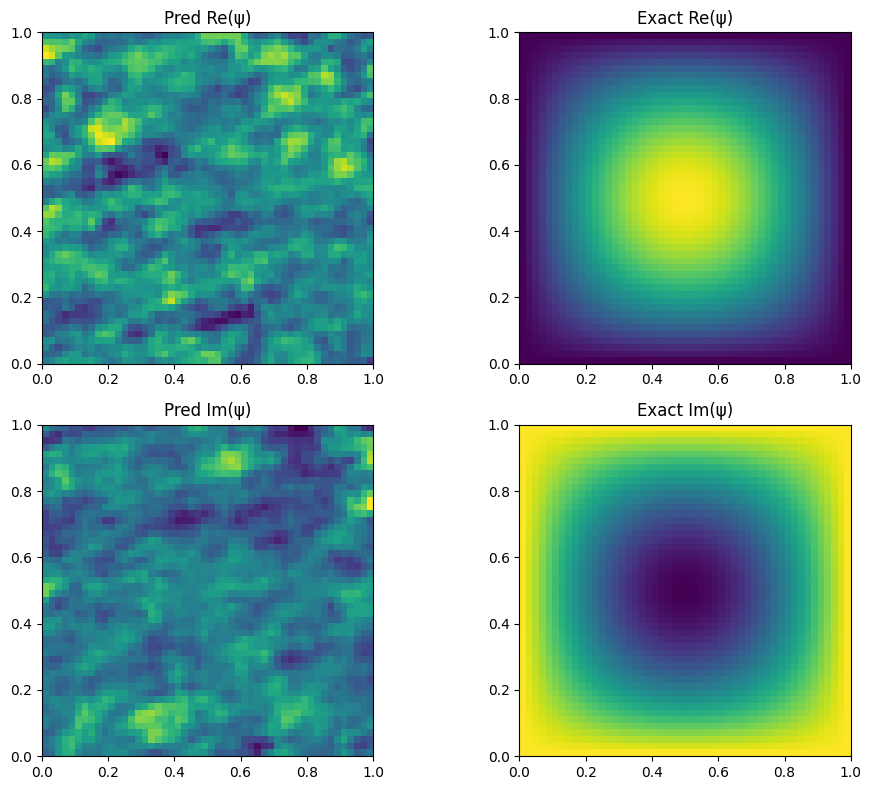

In [9]:
# Comparison with Analytical Solution
hbar = 1.0; m = 1.0
E111 = (3 * np.pi**2 * hbar**2)/(2*m * L**2)
def psi_exact(x, y, z, t):
    val = np.sin(np.pi*x/L)*np.sin(np.pi*y/L)*np.sin(np.pi*z/L)
    return val * np.exp(-1j * E111 * t / hbar)

t0, z0 = 0.5, L/2
n = 50
xs = np.linspace(0, L, n)
ys = np.linspace(0, L, n)
X, Y = np.meshgrid(xs, ys)
xf = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
yf = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
zf = torch.full_like(xf, z0)
tf = torch.full_like(xf, t0)

with torch.no_grad():
    pred = model(fourier_embed(xf,yf,zf,tf)).numpy()
psi_r_pred = pred[:,0].reshape(n,n)
psi_i_pred = pred[:,1].reshape(n,n)

psi_ex = psi_exact(X, Y, z0, t0)
psi_r_ex = psi_ex.real
psi_i_ex = psi_ex.imag

fig, axs = plt.subplots(2,2, figsize=(10,8))
axs[0,0].imshow(psi_r_pred, extent=[0,L,0,L], origin='lower'); axs[0,0].set_title('Pred Re(ψ)')
axs[0,1].imshow(psi_r_ex, extent=[0,L,0,L], origin='lower'); axs[0,1].set_title('Exact Re(ψ)')
axs[1,0].imshow(psi_i_pred, extent=[0,L,0,L], origin='lower'); axs[1,0].set_title('Pred Im(ψ)')
axs[1,1].imshow(psi_i_ex, extent=[0,L,0,L], origin='lower'); axs[1,1].set_title('Exact Im(ψ)')
plt.tight_layout()
plt.show()
